<a href="https://colab.research.google.com/github/towardsai/ai-tutor-rag-system/blob/main/notebooks/05-Improve_Prompts_+_Add_Source.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Packages and Setup Variables


In [1]:
# !pip install -q llama-index==0.14.0 openai==1.107.0 chromadb==1.0.21 llama-index-vector-stores-chroma==0.5.2 \
#                 llama-index-llms-google-genai==0.3.0 jedi==0.19.2

In [2]:
import os

# Set the following API Keys in the Python environment. Will be used later.
# os.environ["OPENAI_API_KEY"] = "<YOUR_API_KEY>"
# os.environ["GOOGLE_API_KEY"] = "<YOUR_API_KEY>"

# from google.colab import userdata
# os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
# os.environ["GOOGLE_API_KEY"] = userdata.get('Google_api_key')

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)  # override=True to overwrite existing environment variables

True

In [3]:
# Allows running asyncio in environments with an existing event loop, like Jupyter notebooks.

import nest_asyncio

nest_asyncio.apply()

In [4]:
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core import Settings

Settings.embed_model = OpenAIEmbedding(
    model="text-embedding-3-small"
)

[nltk_data] Downloading package punkt_tab to c:\DROPBOX\Документы\Карз
[nltk_data]     ановы\Андрей\__CHALLENGES\AI_Full_Stack_Developer\.ven
[nltk_data]     v\Lib\site-
[nltk_data]     packages\llama_index\core\_static/nltk_cache...
[nltk_data]   Package punkt_tab is already up-to-date!
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


# Create a VectoreStore


In [5]:
# import chromadb

# # create client and a new collection
# # chromadb.EphemeralClient saves data in-memory.
# chroma_client = chromadb.PersistentClient(path="./mini-llama-articles")
# chroma_collection = chroma_client.create_collection("mini-llama-articles")

from qdrant_client import QdrantClient, models as qdrant_models

qdrant_client = QdrantClient(url=f"{os.getenv('qdrant_server_id')}:6333")

In [6]:
collection_name = "mini-llama-articles"
qdrant_client.recreate_collection(
    collection_name=collection_name,
    vectors_config=qdrant_models.VectorParams(
        size=1536,  # Size of the embedding vectors
        distance=qdrant_models.Distance.COSINE  # Distance metric
    )
)

C:\Users\User\AppData\Local\Temp\ipykernel_33772\3612244929.py:2: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  qdrant_client.recreate_collection(


True

In [7]:
if qdrant_client.collection_exists(collection_name=collection_name):
    print(f"Collection '{collection_name}' already exists.")
else:
    collection_name = "mini-llama-articles"
    qdrant_client.create_collection(
        collection_name=collection_name,
        vectors_config=qdrant_models.VectorParams(
            size=1536,  # Size of the embedding vectors
            distance=qdrant_models.Distance.COSINE  # Distance metric
        )
    )
    print(f"Collection '{collection_name}' created.")

Collection 'mini-llama-articles' already exists.


In [8]:
# from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.vector_stores.qdrant import QdrantVectorStore

# Define a storage context object using the created vector database.
# vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
vector_store = QdrantVectorStore(
	client=qdrant_client,
	collection_name="mini-llama-articles")

# Load the Dataset (CSV)


## Download


The dataset includes several articles from the TowardsAI blog, which provide an in-depth explanation of the LLaMA2 model.


In [ ]:
# !curl -o ./mini-dataset.csv https://raw.githubusercontent.com/AlaFalaki/tutorial_notebooks/main/data/mini-llama-articles.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  169k  100  169k    0     0   407k      0 --:--:-- --:--:-- --:--:--  407k


## Load the Articles


In [9]:
import csv

rows = []

# Load the file as a JSON
with open("./mini-llama-articles.csv", mode="r", encoding="utf-8") as file:
    csv_reader = csv.reader(file)

    for idx, row in enumerate(csv_reader):
        if idx == 0:
            continue
            # Skip header row
        rows.append(row)

# The number of characters in the dataset.
len(rows)

14

# Convert to Document obj


In [10]:
from llama_index.core import Document

# Convert the chunks to Document objects so the LlamaIndex framework can process them.
documents = [
    Document(
        text=row[1], metadata={"title": row[0], "url": row[2], "source_name": row[3]}
    )
    for row in rows
]

In [11]:
len(documents)

14

In [12]:
print(documents[0].text)
documents[0].metadata

LLM Variants and Meta's Open Source Before shedding light on four major trends, I'd share the latest Meta's Llama 2 and Code Llama. Meta's Llama 2 represents a sophisticated evolution in LLMs. This suite spans models pretrained and fine-tuned across a parameter spectrum of 7 billion to 70 billion. A specialized derivative, Llama 2-Chat, has been engineered explicitly for dialogue-centric applications. Benchmarking revealed Llama 2's superior performance over most extant open-source chat models. Human-centric evaluations, focusing on safety and utility metrics, positioned Llama 2-Chat as a potential contender against proprietary, closed-source counterparts. The development trajectory of Llama 2 emphasized rigorous fine-tuning methodologies. Meta's transparent delineation of these processes aims to catalyze community-driven advancements in LLMs, underscoring a commitment to collaborative and responsible AI development. Code Llama is built on top of Llama 2 and is available in three model

{'title': "Beyond GPT-4: What's New?",
 'url': 'https://pub.towardsai.net/beyond-gpt-4-whats-new-cbd61a448eb9#dda8',
 'source_name': 'towards_ai'}

# Transforming


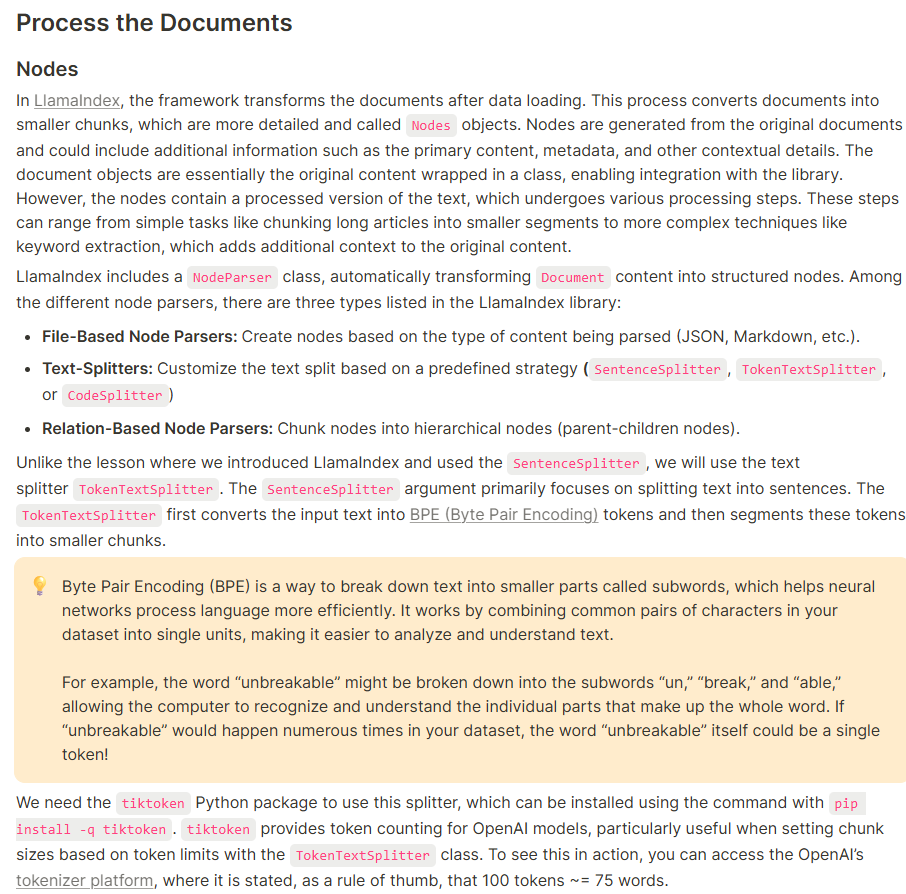

In [ ]:
from llama_index.core.node_parser import TokenTextSplitter

# Define the splitter object that split the text into segments with 512 tokens,
# with a 128 overlap between the segments.
text_splitter = TokenTextSplitter(separator=" ", chunk_size=512, chunk_overlap=128)

In [ ]:
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core.ingestion import IngestionPipeline

# Create the pipeline to apply the transformation (splitting and embedding) on each chunk,
# and store the transformed text in the chroma vector store.
pipeline = IngestionPipeline(
    transformations=[
        text_splitter,
        OpenAIEmbedding(model = 'text-embedding-3-small'),
    ],
    vector_store=vector_store,
)

# Run the transformation pipeline.
b = pipeline.run(documents=documents, show_progress=True)

Parsing nodes:   0%|          | 0/14 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/108 [00:00<?, ?it/s]

# Load Indexes


In [ ]:
# Load the vector store from the local storage.
db = chromadb.PersistentClient(path="./mini-llama-articles")
chroma_collection = db.get_or_create_collection("mini-llama-articles")
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)

In [ ]:
from llama_index.core import VectorStoreIndex

# Create the index based on the vector store.
index = VectorStoreIndex.from_vector_store(vector_store)

In [ ]:
# Define a query engine that is responsible for retrieving related pieces of text,
# and using a LLM to formulate the final answer.

from llama_index.llms.google_genai import GoogleGenAI
import google.genai.types as types

config = types.GenerateContentConfig(
    thinking_config=types.ThinkingConfig(thinking_budget=0),
    max_output_tokens=512,
    temperature=1,
)

llm = GoogleGenAI(
    model="gemini-2.5-flash",
    generation_config=config,
    )

query_engine = index.as_query_engine(llm=llm, similarity_top_k=5)

In [ ]:
res = query_engine.query("How many parameters LLaMA2 model has?")

In [ ]:
res.response

'The LLaMA2 model is available in various sizes, specifically 7 billion, 13 billion, 34 billion, and 70 billion parameters.'

In [ ]:
# Show the retrieved nodes
for src in res.source_nodes:
    print("Node ID\t", src.node_id)
    print("Title\t", src.metadata["title"])
    print("Text\t", src.text)
    print("Score\t", src.score)
    print("-_" * 20)

Node ID	 e1905d39-54c2-4ff1-a289-88b623030250
Title	 Fine-Tuning a Llama-2 7B Model for Python Code Generation
Text	 only fine-tuning a small number of additional parameters, with virtually all model parameters remaining frozen. PEFT has been found to produce good generalization with relatively low-volume datasets. Furthermore, it enhances the reusability and portability of the model, as the small checkpoints obtained can be easily added to the base model, and the base model can be easily fine-tuned and reused in multiple scenarios by adding the PEFT parameters. Finally, since the base model is not adjusted, all the knowledge acquired in the pre-training phase is preserved, thus avoiding catastrophic forgetting. Most widely used PEFT techniques aim to keep the pre-trained base model untouched and add new layers or parameters on top of it. These layers are called "Adapters" and the technique of their adjustment "adapter-tuning", we add these layers to the pre-trained base model and only

# Response Modes


The behavior of the query engine during response generation can be adjusted. Several modes are available for consideration, including the following:

- compact (default): Concatenate all the retrieved chunks and use them in the prompt to generate an answer.
- refine: Generate an answer based on the first retrieved chunk, then improve the answer based on the other retrieved chunks one at a time. (will send one request for each chunk to refine the response)
- tree summarize: concatenate the retrieved chunks until they fit the context window and summarize them. The summaized chunks will then recusively fed back to the LLM for summarization until one chunk remains which would be the final answer.

Refer to [documentation](https://docs.llamaindex.ai/en/stable/module_guides/querying/response_synthesizers/root.html#configuring-the-response-mode) for a comprehensive list.

Due to the limited size of the sample dataset, the examples provided will yield identical responses. It's crucial to evaluate these methods in the context of your specific use case and cost considerations.


In [ ]:
query_engine = index.as_query_engine(response_mode="refine", llm=llm)
#query_engine = index.as_query_engine(response_mode="tree_summarize")

In [ ]:
res = query_engine.query("How many parameters LLaMA 2 model has?")

In [ ]:
res.response

'Rewrite: A Llama-2 7B model is mentioned, which generally indicates 7 billion parameters.'

In [ ]:
# Show the retrieved nodes
for src in res.source_nodes:
    print("Node ID\t", src.node_id)
    print("Title\t", src.metadata["title"])
    print("Text\t", src.text)
    print("Score\t", src.score)
    print("-_" * 20)

Node ID	 e1905d39-54c2-4ff1-a289-88b623030250
Title	 Fine-Tuning a Llama-2 7B Model for Python Code Generation
Text	 only fine-tuning a small number of additional parameters, with virtually all model parameters remaining frozen. PEFT has been found to produce good generalization with relatively low-volume datasets. Furthermore, it enhances the reusability and portability of the model, as the small checkpoints obtained can be easily added to the base model, and the base model can be easily fine-tuned and reused in multiple scenarios by adding the PEFT parameters. Finally, since the base model is not adjusted, all the knowledge acquired in the pre-training phase is preserved, thus avoiding catastrophic forgetting. Most widely used PEFT techniques aim to keep the pre-trained base model untouched and add new layers or parameters on top of it. These layers are called "Adapters" and the technique of their adjustment "adapter-tuning", we add these layers to the pre-trained base model and only

The `no_text` mode will retrieve the documents, but will not send the request to the API to synthesize the final response. It is a great approach to debug the retrieved documents.


In [ ]:
query_engine = index.as_query_engine(response_mode="no_text", llm=llm)
res = query_engine.query("How many parameters LLaMA 2 model has?")

In [ ]:
res.response

''

In [ ]:
# Show the retrieved nodes
for src in res.source_nodes:
    print("Node ID\t", src.node_id)
    print("Title\t", src.metadata["title"])
    print("Text\t", src.text)
    print("Score\t", src.score)
    print("-_" * 20)

Node ID	 e1905d39-54c2-4ff1-a289-88b623030250
Title	 Fine-Tuning a Llama-2 7B Model for Python Code Generation
Text	 only fine-tuning a small number of additional parameters, with virtually all model parameters remaining frozen. PEFT has been found to produce good generalization with relatively low-volume datasets. Furthermore, it enhances the reusability and portability of the model, as the small checkpoints obtained can be easily added to the base model, and the base model can be easily fine-tuned and reused in multiple scenarios by adding the PEFT parameters. Finally, since the base model is not adjusted, all the knowledge acquired in the pre-training phase is preserved, thus avoiding catastrophic forgetting. Most widely used PEFT techniques aim to keep the pre-trained base model untouched and add new layers or parameters on top of it. These layers are called "Adapters" and the technique of their adjustment "adapter-tuning", we add these layers to the pre-trained base model and only